In [1]:
import math
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.animation as animation 
%matplotlib notebook
import mpl_toolkits.mplot3d.axes3d as p3
from scipy.integrate import odeint

# define spacecraft mass, inertia, external torque, and state

In [18]:
# define inertia
m = 1.33 # kg
l = 0.1 # m
I_xx = 1/12*m*(2*l**2) # kg m^2
I_yy = 1/12*m*(2*l**2) # kg m^2
I_zz = 1/12*m*(2*l**2) # kg m^2
I = np.array([[I_xx, 0, 0],[0, I_yy, 0],[0, 0 ,I_zz]])

# define external torque
tau = np.array([[0],[0], [0]])

# define initial state
# euler angles
phi = np.pi/4      # "roll" FEEL FREE TO CHANGE THIS VALUE
theta = np.pi/4       # "pitch" FEEL FREE TO CHANGE THIS VALUE
psi = np.pi/4      # "yaw" FEEL FREE TO CHANGE THIS VALUE
# rotation matrix 
A_x = np.array([[1, 0, 0],
               [0, np.cos(phi), -np.sin(phi)], 
               [0, np.sin(phi), np.cos(phi)]])
A_y = np.array([[np.cos(theta), 0, np.sin(theta)],
               [0, 1, 0], 
               [-np.sin(theta), 0, np.cos(theta)]])
A_z = np.array([[np.cos(psi), -np.sin(psi), 0],
               [np.sin(psi), np.cos(psi), 0], 
               [0, 0, 1]])
A = A_z @ A_y @ A_x
# euler axis angle
theta_a = np.arccos((A[0,0]+A[1,1]+A[2,2]-1)/2)
e_1 = (A[2,1]-A[1,2])/(2*np.sin(theta_a))
e_2 = (A[0,2]-A[2,0])/(2*np.sin(theta_a))
e_3 = (A[1,0]-A[0,1])/(2*np.sin(theta_a))
# quaternion
q_x0 = e_1*np.sin(theta_a/2)
q_y0 = e_2*np.sin(theta_a/2)
q_z0 = e_3*np.sin(theta_a/2)
q_w0 = np.cos(theta_a/2)
q_0 = np.array([q_x0, q_y0, q_z0, q_w0])

omega_x0 = 10*np.pi/180 # roll velocity
omega_y0 = 0 # pitch velocity
omega_z0 = 0 # yaw velocity
omega_0 = np.array([omega_x0,omega_y0,omega_z0])

## now define the initial state using the rotation matrix as a part of the state

In [3]:
# initiate state with rotation matrix
r_0 = np.concatenate((A[0,:], A[1,:], A[2,:]))
s_0 = np.concatenate((r_0,omega_0), axis=0)

# encode the ordinary differential equation that defines the state derivative with respect to a quaternion state
## derived from Euler's rigid body dynamics equation¶

In [19]:
# ode for kinematics/dynamics using rotation matrix state
def R_model(s,t,I,tau):
    # break out state
    r = s[0:9]
    R = np.array([r[0:3],r[3:6],r[6:9]])
    w1 = s[9]
    w2 = s[10]
    w3 = s[11]
    w = np.array([[w1],[w2],[w3]])
    
    # define derivative
    wcross = np.array([[0,w3,-w2],[-w3,0,w1],[w2,-w1,0]])
    
    Rdot = R@wcross
    rdot = np.concatenate((Rdot[0,:], Rdot[1,:], Rdot[2,:]))
    
    wdot = -np.linalg.inv(I)@(wcross@I@w-tau)
    
    # return state derivative
    sdot = np.concatenate((rdot,wdot[:,0]), axis=0)
    
    return sdot

## run the dynamics model with no external torque and plot the resulting attitude dynamics of the spacecraft

<IPython.core.display.Javascript object>


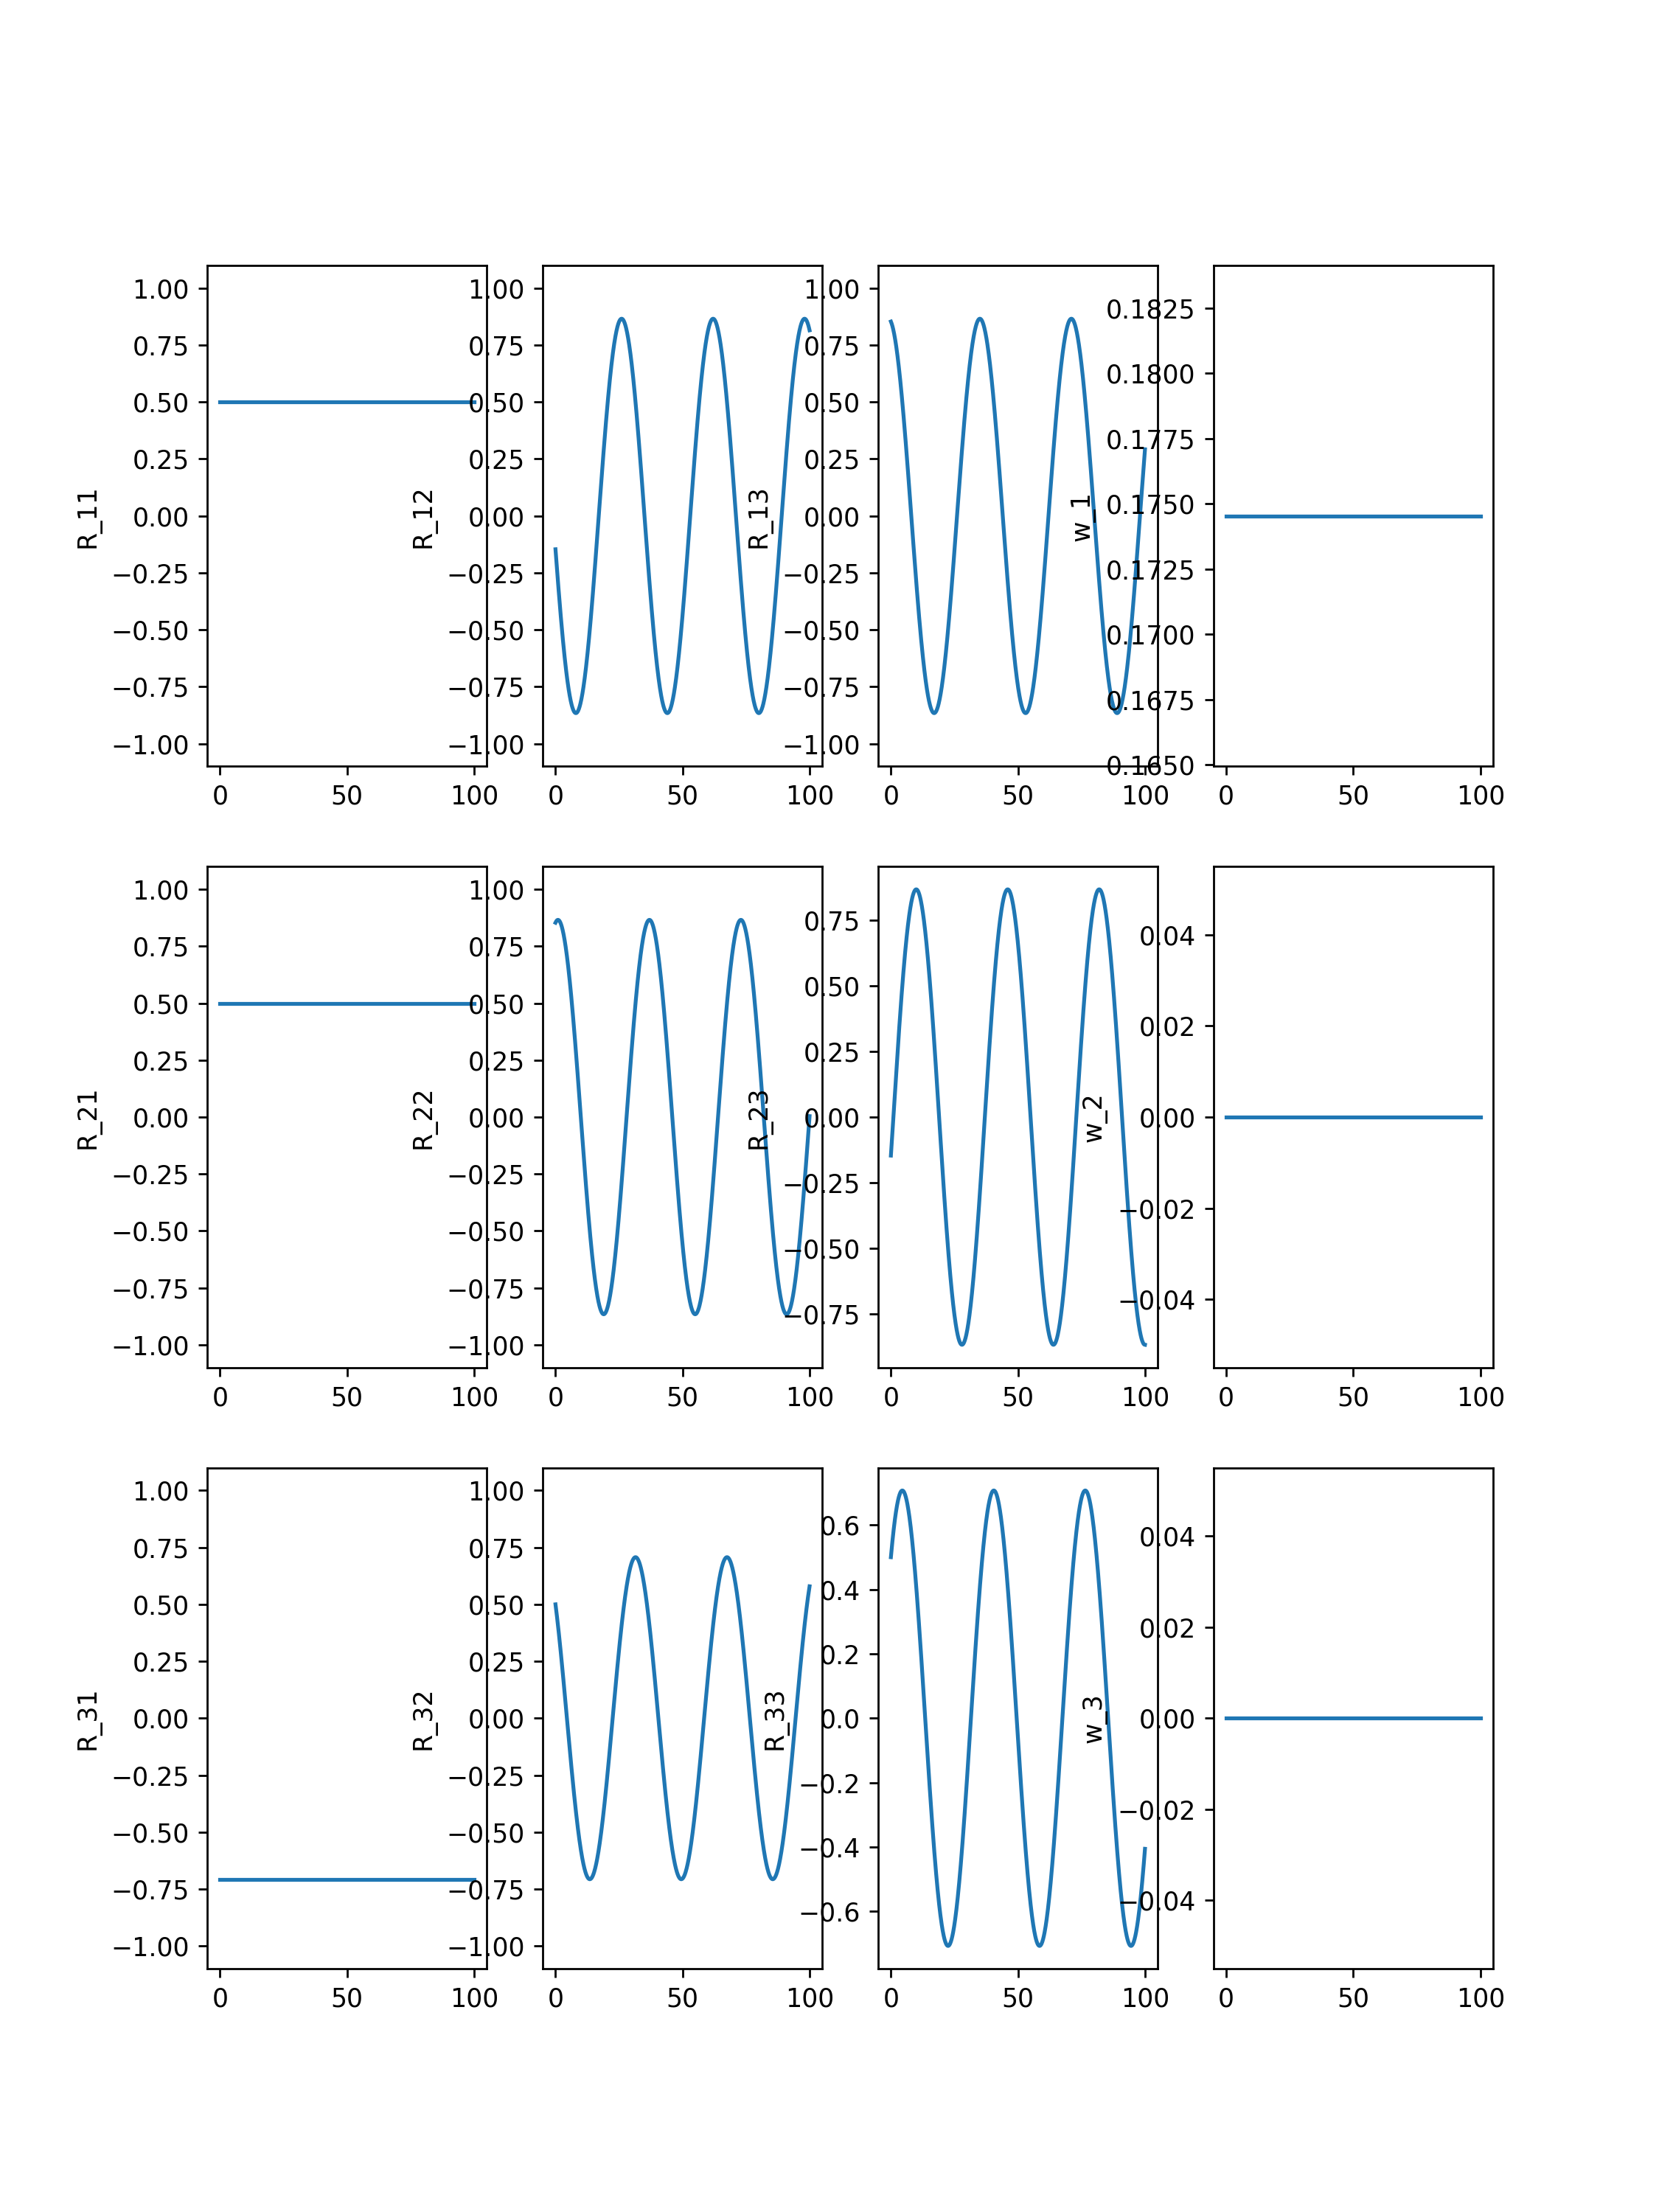

Text(0, 0.5, 'w_3')

In [20]:
# time points
t = np.linspace(0, 100, 1001)

# integrate
y = odeint(R_model, s_0, t, args=(I,tau))
R_t = y[:,0:9]
w_t = y[:,9::]

fig = plt.figure(figsize=(9,12))
plt.subplot(3,4,1)
plt.plot(t,R_t[:,0])
plt.ylabel('R_11')
plt.ylim(-1.1,1.1)
plt.subplot(342)
plt.plot(t,R_t[:,1])
plt.ylabel('R_12')
plt.ylim(-1.1,1.1)
plt.subplot(343)
plt.plot(t,R_t[:,2])
plt.ylabel('R_13')
plt.ylim(-1.1,1.1)
plt.subplot(344)
plt.plot(t,w_t[:,0])
plt.ylabel('w_1')
plt.subplot(345)
plt.plot(t,R_t[:,3])
plt.ylabel('R_21')
plt.ylim(-1.1,1.1)
plt.subplot(346)
plt.plot(t,R_t[:,4])
plt.ylabel('R_22')
plt.ylim(-1.1,1.1)
plt.subplot(347)
plt.plot(t,R_t[:,5])
plt.ylabel('R_23')
plt.subplot(348)
plt.plot(t,w_t[:,1])
plt.ylabel('w_2')
plt.subplot(349)
plt.plot(t,R_t[:,6])
plt.ylabel('R_31')
plt.ylim(-1.1,1.1)
plt.subplot(3,4,10)
plt.plot(t,R_t[:,7])
plt.ylabel('R_32')
plt.ylim(-1.1,1.1)
plt.subplot(3,4,11)
plt.plot(t,R_t[:,8])
plt.ylabel('R_33')
plt.subplot(3,4,12)
plt.plot(t,w_t[:,2])
plt.ylabel('w_3')


<IPython.core.display.Javascript object>


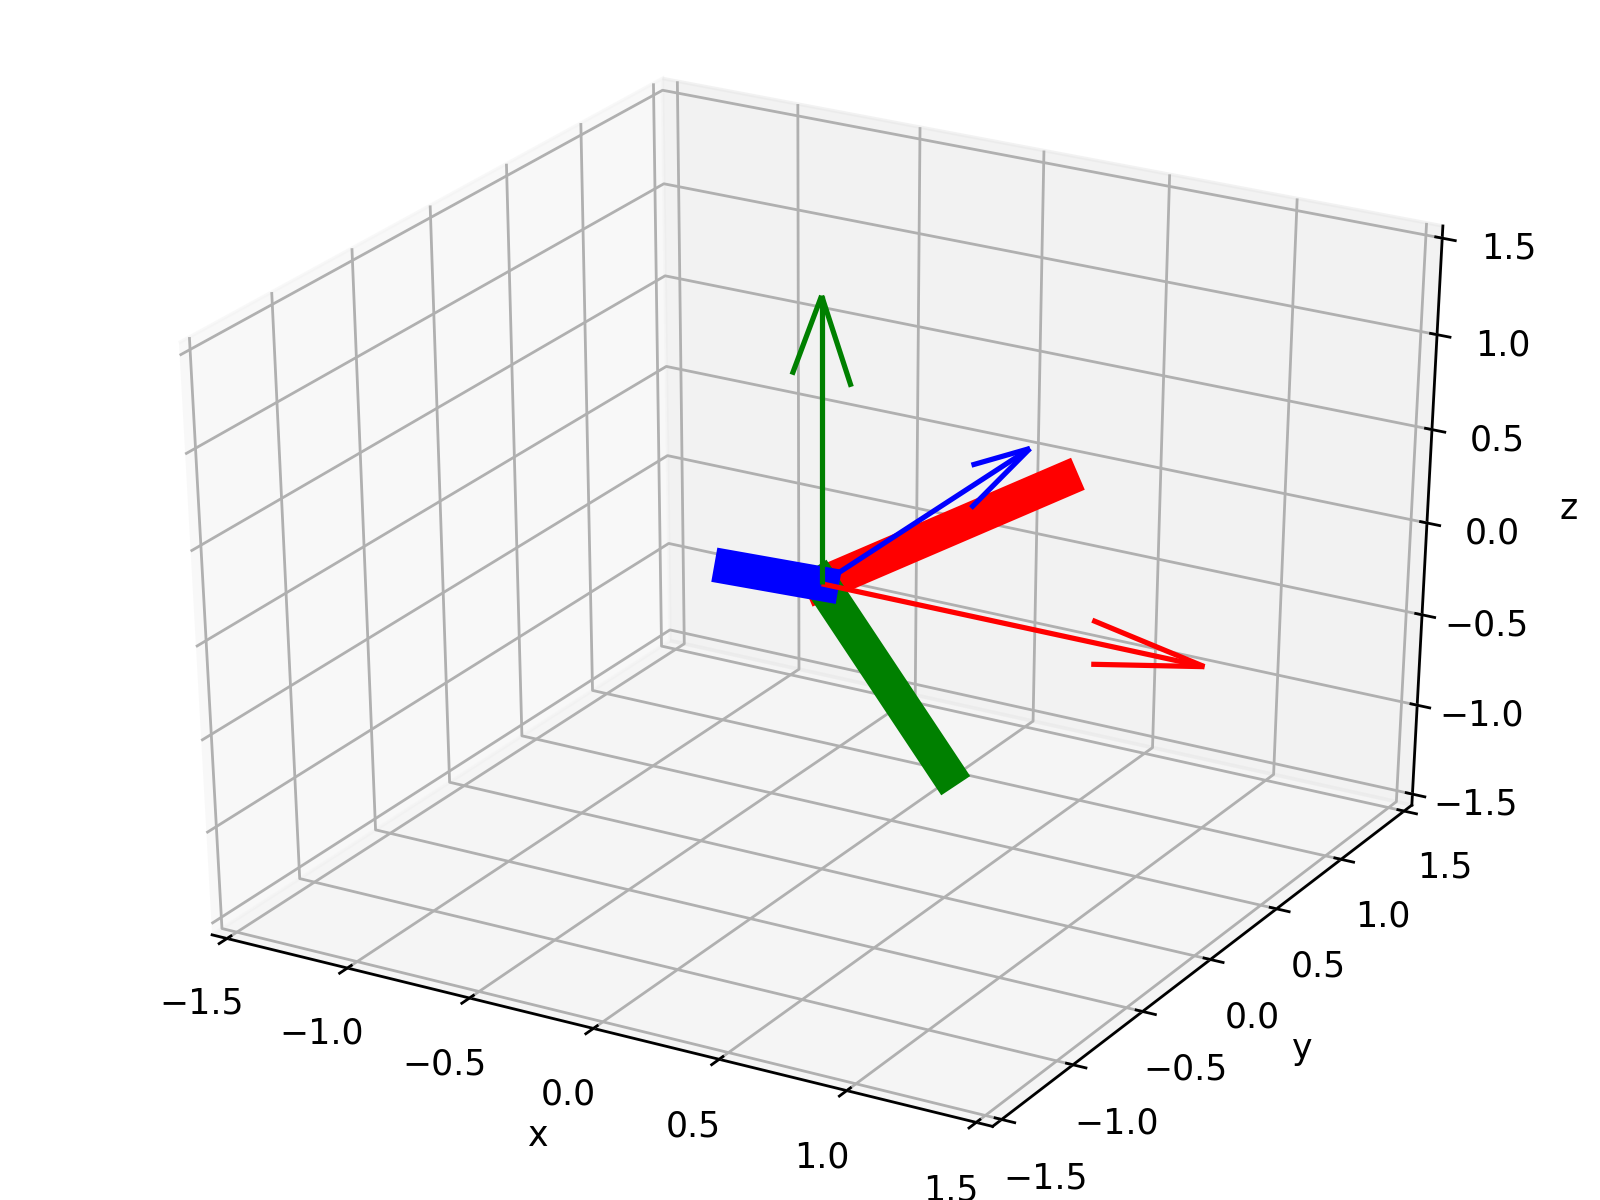

In [21]:
# animate what this rotation looks like
fig = plt.figure()
ax = p3.Axes3D(fig)
plt3d = fig.gca(projection='3d')
# object initialization
i = 0
ax.quiver(0, 0, 0, 1, 0, 0, length=1.5, normalize=True, color = 'red')
ax.quiver(0, 0, 0, 0, 1, 0, length=1.5, normalize=True, color = 'blue')
ax.quiver(0, 0, 0, 0, 0, 1, length=1.5, normalize=True, color = 'green')
ax.set(xlim=(-1.5,1.5), 
          ylim=(-1.5,1.5), 
          zlim=(-1.5,1.5))
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

x_b, = ax.plot([0,R_t[0,0]], [0,R_t[0,3]], [0,R_t[0,6]], color = 'red', linewidth = 10)
y_b, = ax.plot([0,R_t[0,1]], [0,R_t[0,4]], [0,R_t[0,7]], color = 'green', linewidth = 10)
z_b, = ax.plot([0,R_t[0,2]], [0,R_t[0,5]], [0,R_t[0,8]], color = 'blue', linewidth = 10)

# object update
for n in range(1,len(t)):
    x_b.set_data([0,R_t[n,0]], [0,R_t[n,1]])
    x_b.set_3d_properties([0,R_t[n,2]], 'z')
    y_b.set_data([0,R_t[n,3]], [0,R_t[n,4]])
    y_b.set_3d_properties([0,R_t[n,5]], 'z')
    z_b.set_data([0,R_t[n,6]], [0,R_t[n,7]])
    z_b.set_3d_properties([0,R_t[n,8]], 'z')

    fig.canvas.draw()
    fig.canvas.flush_events()
plt.show()

# now let's investigate motion using the quaternion kinematics

In [10]:
# initiate state with quaternion
s_0 = np.concatenate((q_0,omega_0), axis=0)

# code the ordinary differential equation that defines the state derivative with respect to a quaternion state
## derived from Euler's rigid body dynamics equation

In [22]:
# ode for kinematics/dynamics using quaternion state
def q_model(s,t,I,tau):
    # break out state
    q1 = s[0]
    q2 = s[1]
    q3 = s[2]
    q4 = s[3]
    w1 = s[4]
    w2 = s[5]
    w3 = s[6]
    w = np.array([[w1],[w2],[w3]])
    
    # define derivative
    qmat = np.array([[q4, -q3, q2],
                     [q3, q4, -q1],
                     [-q2, q1, q4],
                     [-q1, -q2, -q3]])
    qdot = 1/2*qmat@w
    
    wcross = np.array([[0,-w3,w2],
                       [w3,0,-w1],
                       [-w2,w1,0]])
    wdot = -np.linalg.inv(I)@(wcross@(I@w)-tau)

    # return state derivative
    sdot = np.concatenate((qdot[:,0],wdot[:,0]), axis=0)
    
    return sdot

## run the dynamics model with no external torque

In [12]:
# time points
t = np.linspace(0, 100, 1001)

# integrate
y = odeint(q_model, s_0, t, args=(I,tau))

## plot the resulting attitude dynamics of the spacecraft

<IPython.core.display.Javascript object>


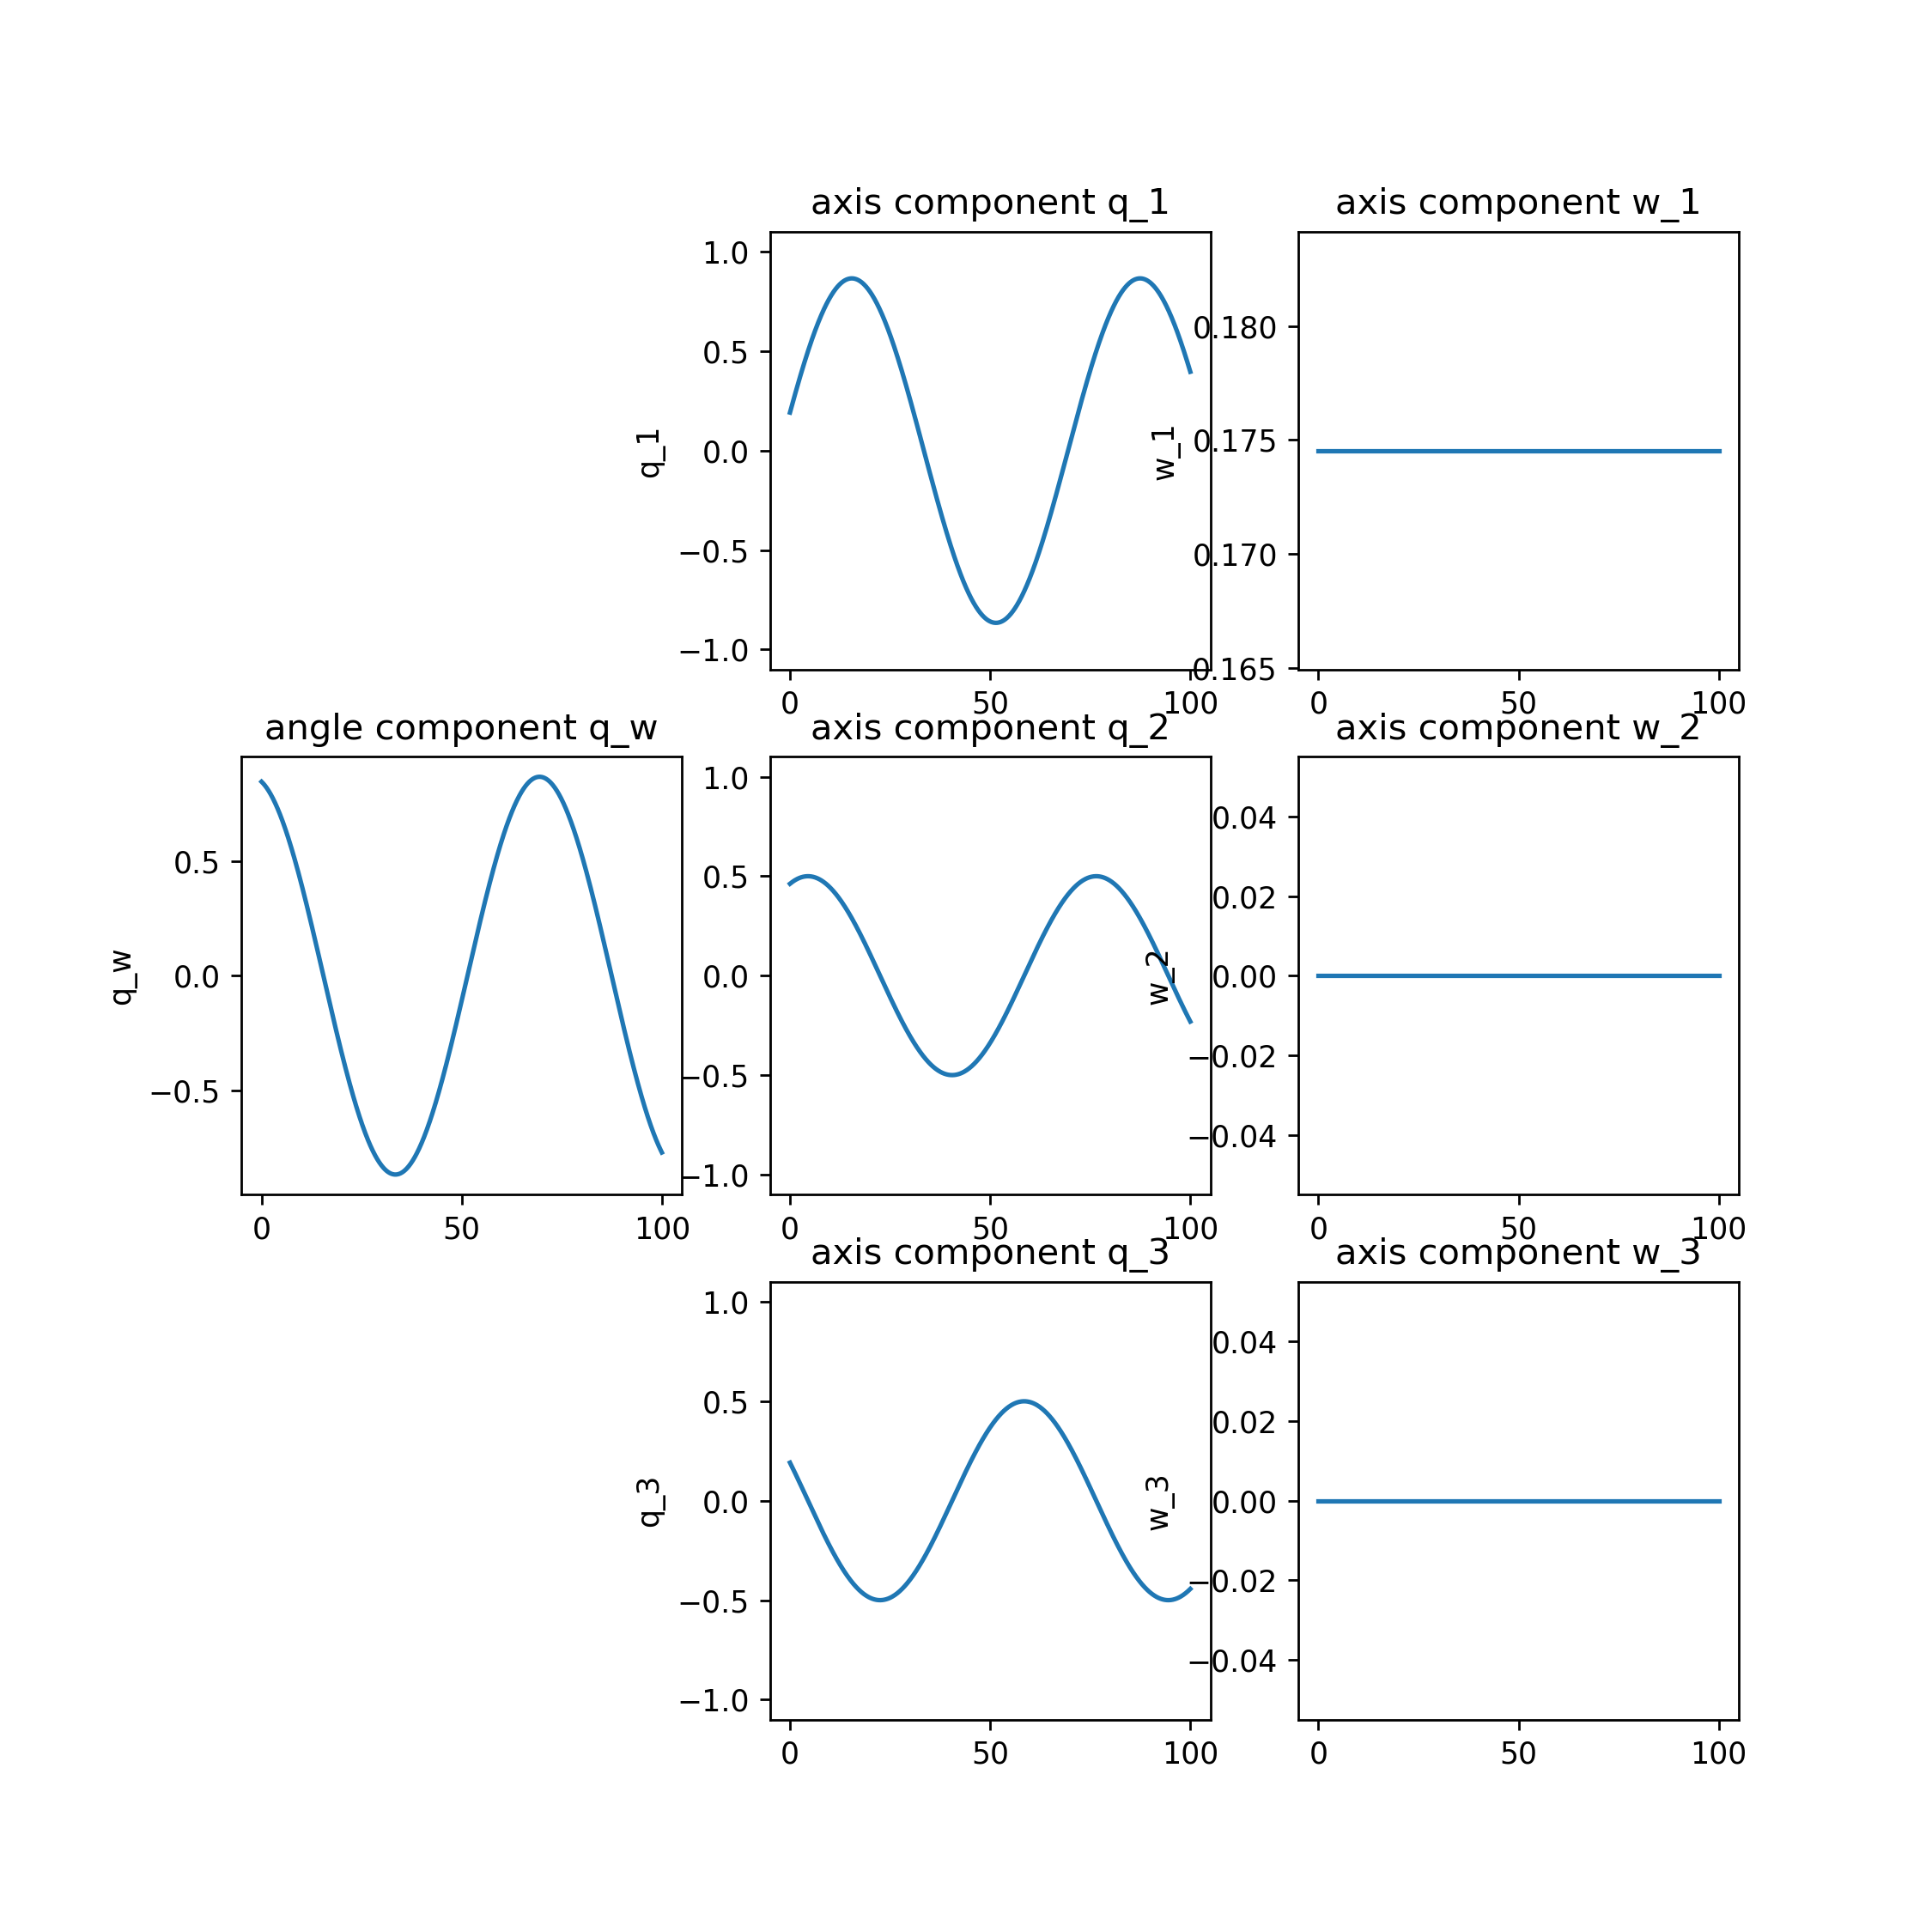

Text(0.5, 1.0, 'axis component w_3')

In [13]:
q_t = y[:,0:4]
# for i in range(len(q_t)):
#     q = q_t[i,:]
#     qmag = np.sqrt(q.dot(q))
#     q_t[i,:] = q/qmag
#     print(qmag)
w_t = y[:,4:7]

fig = plt.figure(figsize=(9,9))
plt.subplot(332)
plt.plot(t,q_t[:,0])
plt.ylabel('q_1')
plt.title('axis component q_1')
plt.ylim(-1.1,1.1)
plt.subplot(335)
plt.plot(t,q_t[:,1])
plt.ylabel('q_2')
plt.title('axis component q_2')
plt.ylim(-1.1,1.1)
plt.subplot(338)
plt.plot(t,q_t[:,2])
plt.ylabel('q_3')
plt.title('axis component q_3')
plt.ylim(-1.1,1.1)
plt.subplot(334)
plt.plot(t,q_t[:,3])
plt.ylabel('q_w')
plt.title('angle component q_w')
plt.subplot(333)
plt.plot(t,w_t[:,0])
plt.ylabel('w_1')
plt.title('axis component w_1')
plt.subplot(336)
plt.plot(t,w_t[:,1])
plt.ylabel('w_2')
plt.title('axis component w_2')
plt.subplot(339)
plt.plot(t,w_t[:,2])
plt.ylabel('w_3')
plt.title('axis component w_3')


# off-diagonal inertia products

<IPython.core.display.Javascript object>


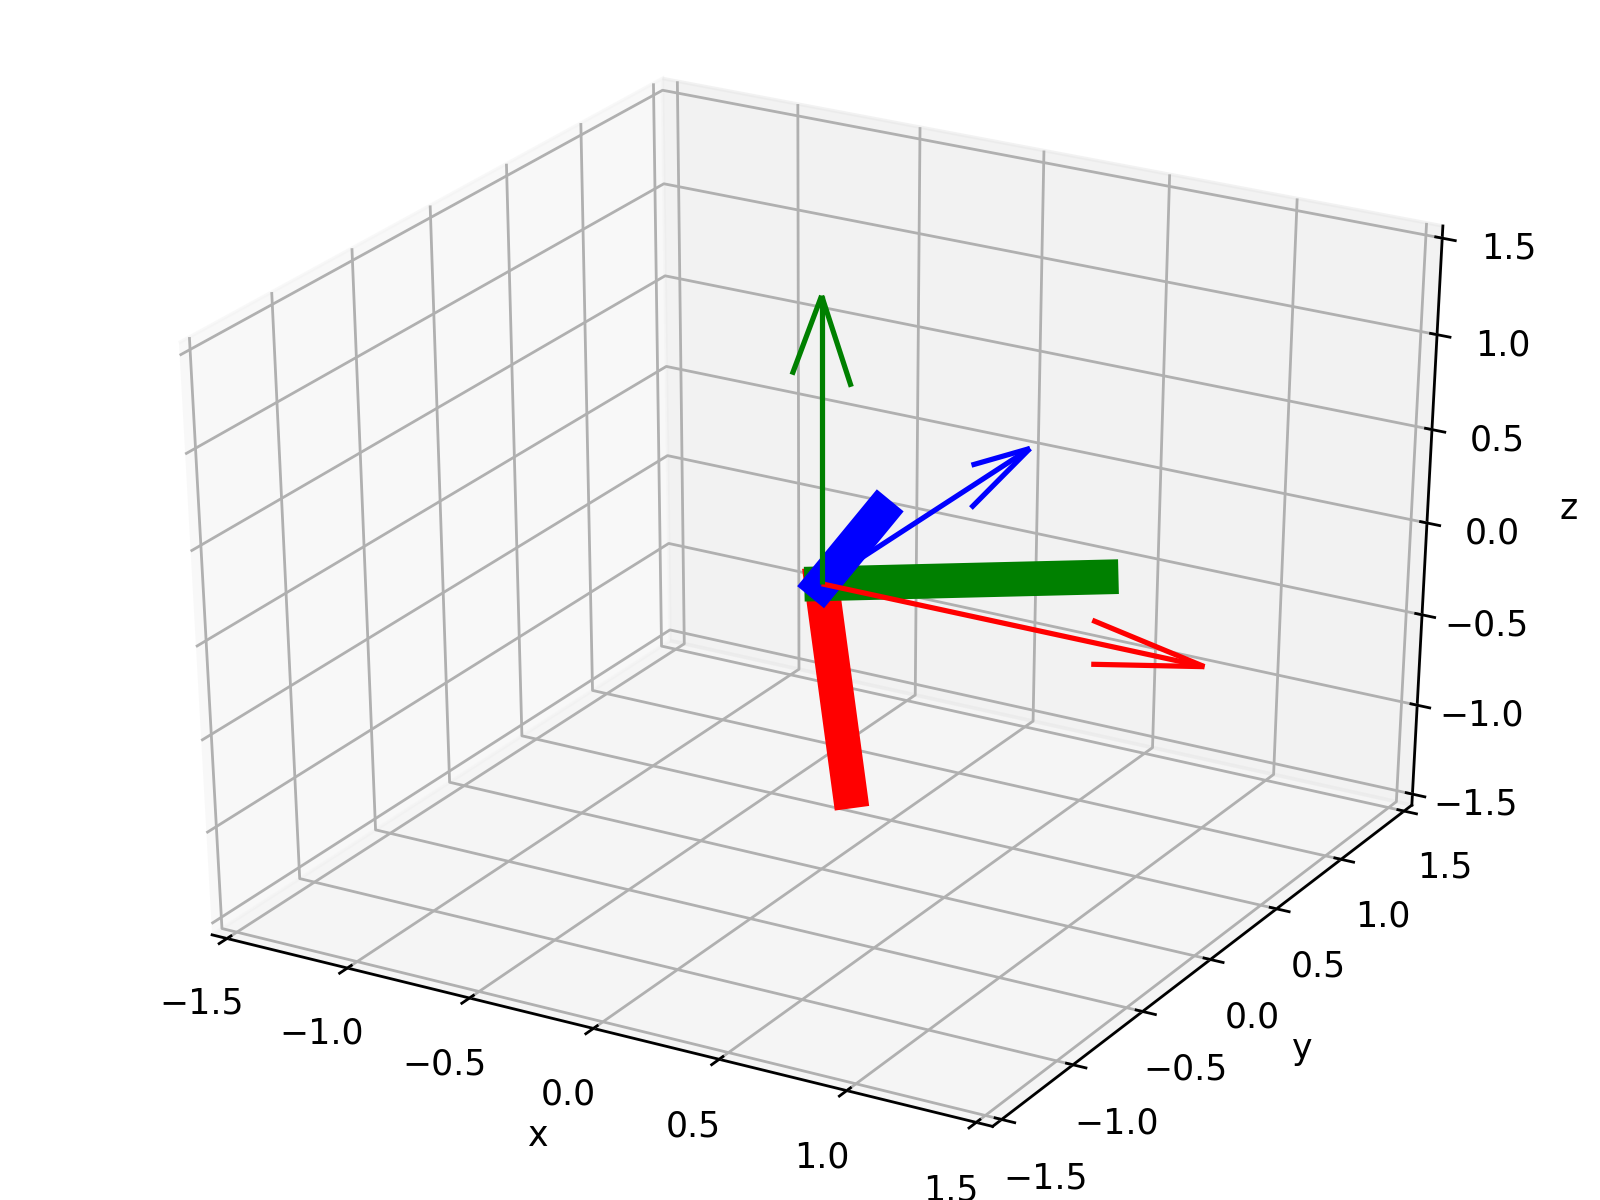

In [23]:
# add off-diagonal inertia to inertia matrix FEEL FREE TO MODIFY
I = np.array([[I_xx, 0.5*I_xx, 0],[0.5*I_xx, I_yy, 0],[0, 0 ,I_zz]])

# time points
t = np.linspace(0, 100, 1001)

#external torque
tau = np.array([[0],[0],[0]])

# initiate state with rotation matrix
r_0 = np.concatenate((A[0,:], A[1,:], A[2,:]))
s_0 = np.concatenate((r_0,omega_0), axis=0)

# integrate
y = odeint(R_model, s_0, t, args=(I,tau))
R_t = y[:,0:9]
w_t = y[:,9::]

# animate what this rotation looks like
fig = plt.figure()
ax = p3.Axes3D(fig)
plt3d = fig.gca(projection='3d')
# object initialization
i = 0
ax.quiver(0, 0, 0, 1, 0, 0, length=1.5, normalize=True, color = 'red')
ax.quiver(0, 0, 0, 0, 1, 0, length=1.5, normalize=True, color = 'blue')
ax.quiver(0, 0, 0, 0, 0, 1, length=1.5, normalize=True, color = 'green')
ax.set(xlim=(-1.5,1.5), 
          ylim=(-1.5,1.5), 
          zlim=(-1.5,1.5))
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

x_b, = ax.plot([0,R_t[0,0]], [0,R_t[0,3]], [0,R_t[0,6]], color = 'red', linewidth = 10)
y_b, = ax.plot([0,R_t[0,1]], [0,R_t[0,4]], [0,R_t[0,7]], color = 'green', linewidth = 10)
z_b, = ax.plot([0,R_t[0,2]], [0,R_t[0,5]], [0,R_t[0,8]], color = 'blue', linewidth = 10)

# object update
for n in range(1,len(t)):
    x_b.set_data([0,R_t[n,0]], [0,R_t[n,1]])
    x_b.set_3d_properties([0,R_t[n,2]], 'z')
    y_b.set_data([0,R_t[n,3]], [0,R_t[n,4]])
    y_b.set_3d_properties([0,R_t[n,5]], 'z')
    z_b.set_data([0,R_t[n,6]], [0,R_t[n,7]])
    z_b.set_3d_properties([0,R_t[n,8]], 'z')

    fig.canvas.draw()
    fig.canvas.flush_events()
plt.show()

# result of external torques

<IPython.core.display.Javascript object>


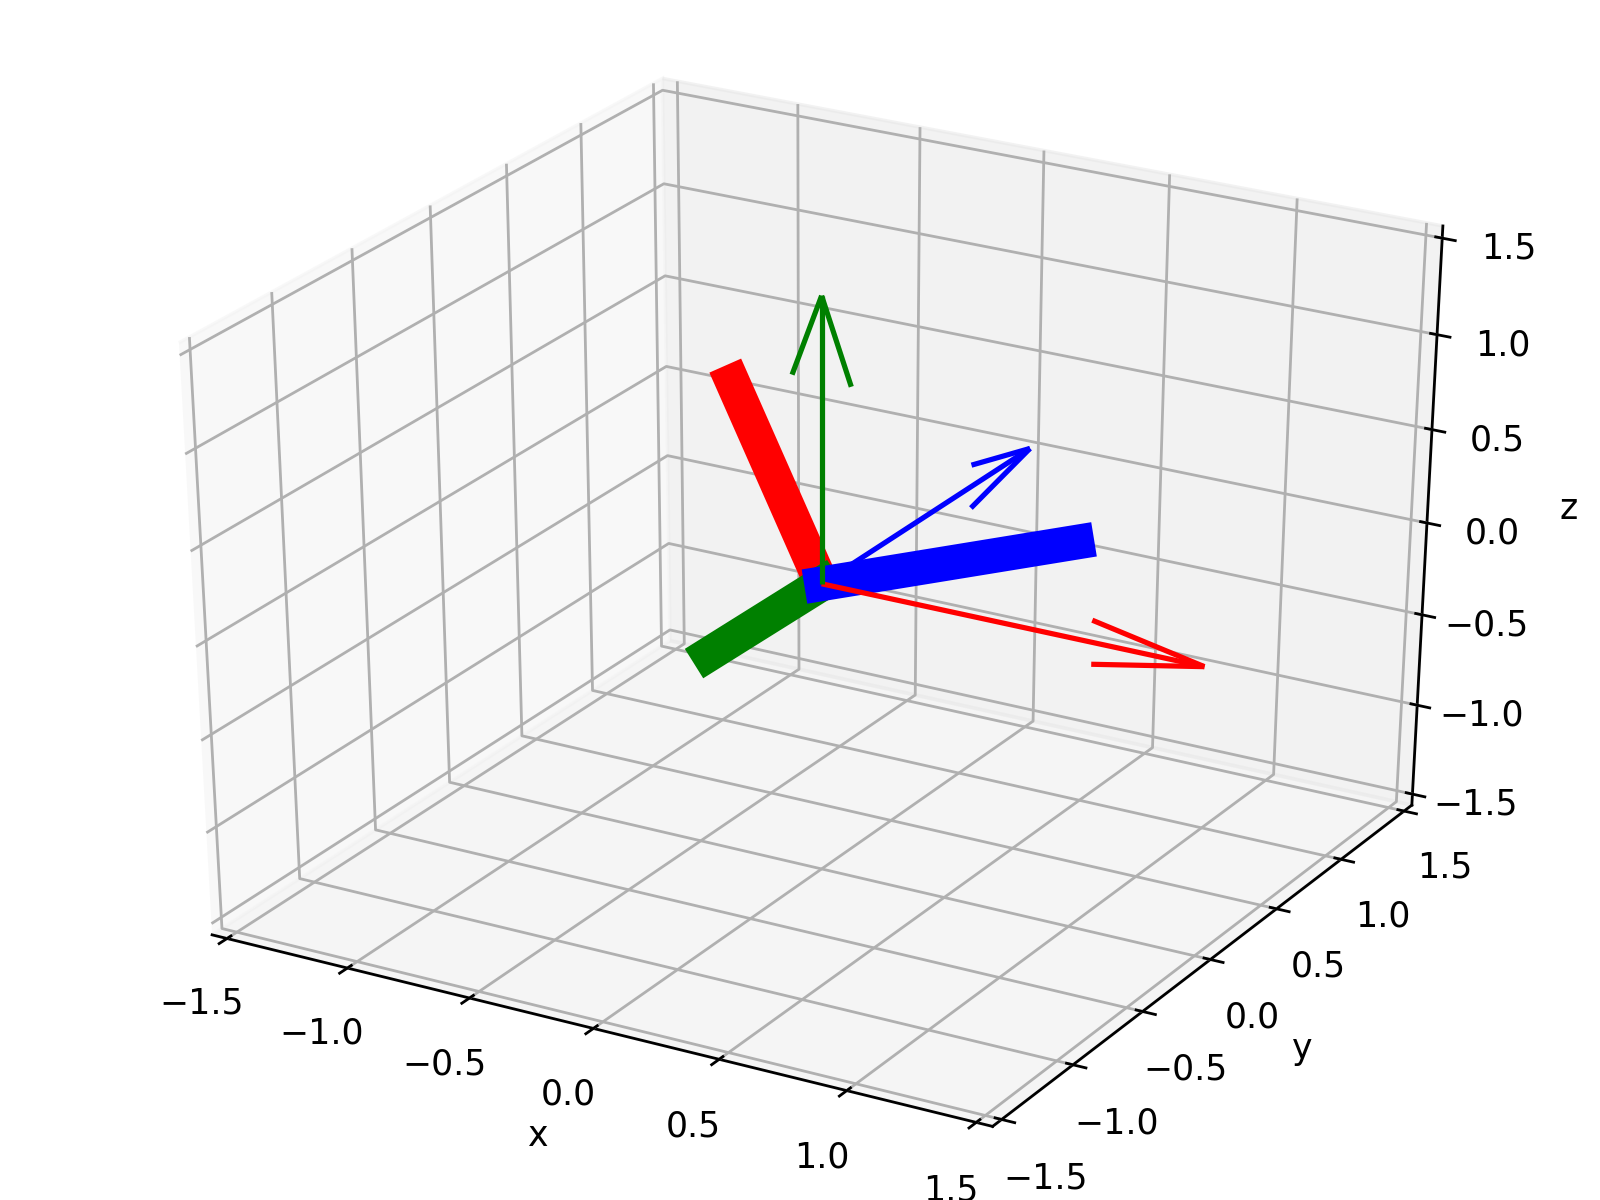

In [28]:
# add off-diagonal inertia to inertia matrix 
I = np.array([[I_xx, 0, 0],[0, I_yy, 0],[0, 0 ,I_zz]])

# time points
t = np.linspace(0, 10, 101)

#external torque FEEL FREE TO MODIFY
tau = np.array([[0],[0],[.001]])

# initiate state with rotation matrix
r_0 = np.concatenate((A[0,:], A[1,:], A[2,:]))
s_0 = np.concatenate((r_0,omega_0), axis=0)

# integrate
y = odeint(R_model, s_0, t, args=(I,tau))
R_t = y[:,0:9]
w_t = y[:,9::]

# animate what this rotation looks like
fig = plt.figure()
ax = p3.Axes3D(fig)
plt3d = fig.gca(projection='3d')
# object initialization
i = 0
ax.quiver(0, 0, 0, 1, 0, 0, length=1.5, normalize=True, color = 'red')
ax.quiver(0, 0, 0, 0, 1, 0, length=1.5, normalize=True, color = 'blue')
ax.quiver(0, 0, 0, 0, 0, 1, length=1.5, normalize=True, color = 'green')
ax.set(xlim=(-1.5,1.5), 
          ylim=(-1.5,1.5), 
          zlim=(-1.5,1.5))
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

x_b, = ax.plot([0,R_t[0,0]], [0,R_t[0,3]], [0,R_t[0,6]], color = 'red', linewidth = 10)
y_b, = ax.plot([0,R_t[0,1]], [0,R_t[0,4]], [0,R_t[0,7]], color = 'green', linewidth = 10)
z_b, = ax.plot([0,R_t[0,2]], [0,R_t[0,5]], [0,R_t[0,8]], color = 'blue', linewidth = 10)

# object update
for n in range(1,len(t)):
    x_b.set_data([0,R_t[n,0]], [0,R_t[n,1]])
    x_b.set_3d_properties([0,R_t[n,2]], 'z')
    y_b.set_data([0,R_t[n,3]], [0,R_t[n,4]])
    y_b.set_3d_properties([0,R_t[n,5]], 'z')
    z_b.set_data([0,R_t[n,6]], [0,R_t[n,7]])
    z_b.set_3d_properties([0,R_t[n,8]], 'z')

    fig.canvas.draw()
    fig.canvas.flush_events()
plt.show()